In [1]:
import time
import pandas as pd
from IPython.display import display_html
from matplotlib import pyplot as plt

## load image

In [2]:
import numpy as np
import os
import PIL
from PIL import Image, ImageOps
PIL.Image.MAX_IMAGE_PIXELS = 933120000

cached_img_load = {}

def get_files(name,path):
    if not os.path.isdir(path):
        return [(name,path)]
    else:
        targets = [
            f for f in os.listdir(path) if not os.path.isdir(os.path.join(path, f))
        ]
        return [
            (name + '/' + f, os.path.join(path, f)) for f in targets
        ]

def load_image(name,path):
    try:
        image = Image.open(path)
        # https://stackoverflow.com/questions/63947990/why-are-width-and-height-of-an-image-are-inverted-when-loading-using-pil-versus
        image = ImageOps.exif_transpose(image)

        img = np.array(image.convert('RGB'))
        dpi = image.info.get("dpi")

        print("name: ", name, 'dpi:', dpi)

        cached_img_load[name] = (img,dpi)
    except Exception as e:
        print("skip: ", path)

In [3]:
files = get_files("images", os.path.abspath("../images/radon-transform"))
for n,f in files:
    load_image(n,f)

name:  images/skew-linedetection.png dpi: (72.009, 72.009)


## preprocess image

name:  images/skew-linedetection.png time:  0.015183 seconds


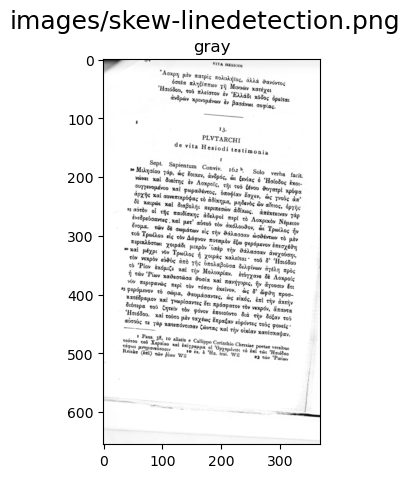

In [4]:
import cv2

cached_img_preprocess = {}

for name,(img,_) in cached_img_load.items():
    start = time.time()

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    end = time.time()
    cached_img_preprocess[name] = gray


    print("name: ", name, "time: ", "{:.6f} seconds".format(end - start))

    # show the output image
    show_imgs = [
        ("gray", gray),
    ]
    show_count = len(show_imgs)
    fig = plt.figure(figsize=(show_count * 5,5))
    fig.suptitle(name, fontsize=18)
    gs = fig.add_gridspec(1,show_count)
    for idx, (name,img) in enumerate(show_imgs):
        if img is None: continue
        ax = fig.add_subplot(gs[0, idx])
        ax.set_title(name)
        ax.imshow(img, cmap='gray')

## radon transform

name:  images/skew-linedetection.png time: 2.444618 seconds


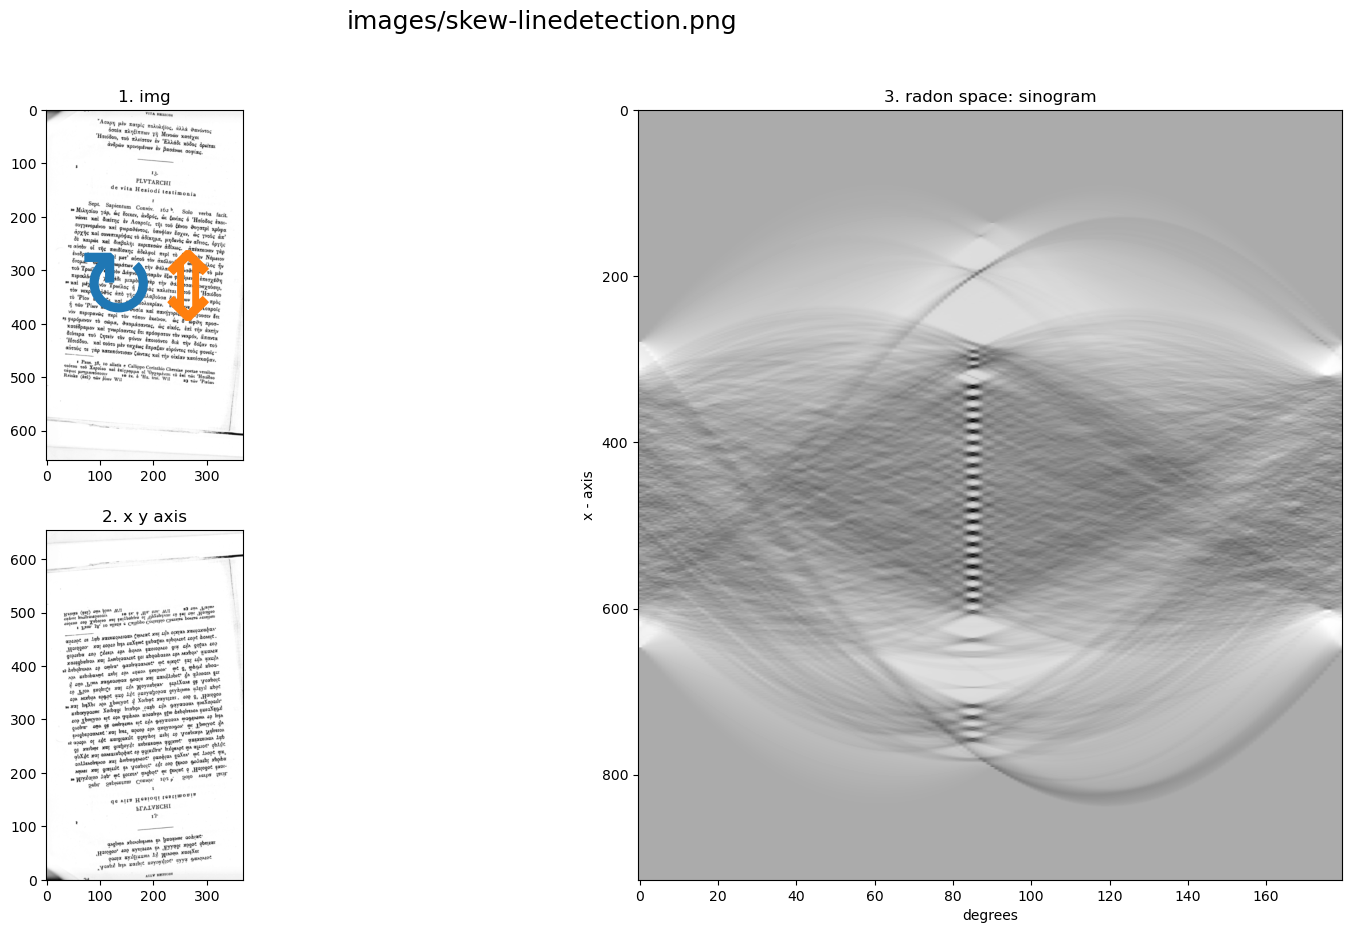

In [17]:
from skimage.transform import radon
from numpy import mean

cached_radon_space = {}

for name,img in cached_img_preprocess.items():
    start = time.time()

    # Demean; make the brightness extend above and below zero
    I = img - mean(img)
    # Do the radon transform and display the result
    sinogram = radon(I, circle=False)

    end = time.time()
    cached_radon_space[name] = (sinogram)


    print("name: ", name, "time:", "{:.6f} seconds".format(end - start))

    fig = plt.figure(figsize=(20,10))
    fig.suptitle(name, fontsize=18)
    gs = fig.add_gridspec(2,2)

    ax = fig.add_subplot(gs[0,0])
    ax.set_title(f"1. img")
    ax.imshow(img, cmap="gray")
    ax.plot(img.shape[1] * 1/3, img.shape[0] / 2, marker=r'$\circlearrowright$', ms=50)
    ax.plot(img.shape[1] * 2/3, img.shape[0] / 2, marker=r'$\Updownarrow$', ms=50)

    ax = fig.add_subplot(gs[1,0])
    ax.set_title(f"2. x y axis")
    ax.set_ylim(0, img.shape[0])
    ax.imshow(img, cmap="gray")
    
    ax = fig.add_subplot(gs[:,1])
    ax.set_title(f"3. radon space: sinogram")
    ax.set_xlabel("degrees")
    ax.set_ylabel("x - axis")
    ax.imshow(sinogram, cmap="gray", aspect='auto')

## most angle

name:  images/skew-linedetection.png time:  0.001110 seconds


,angle degree,rotation degree
images/skew-linedetection.png,-5,5


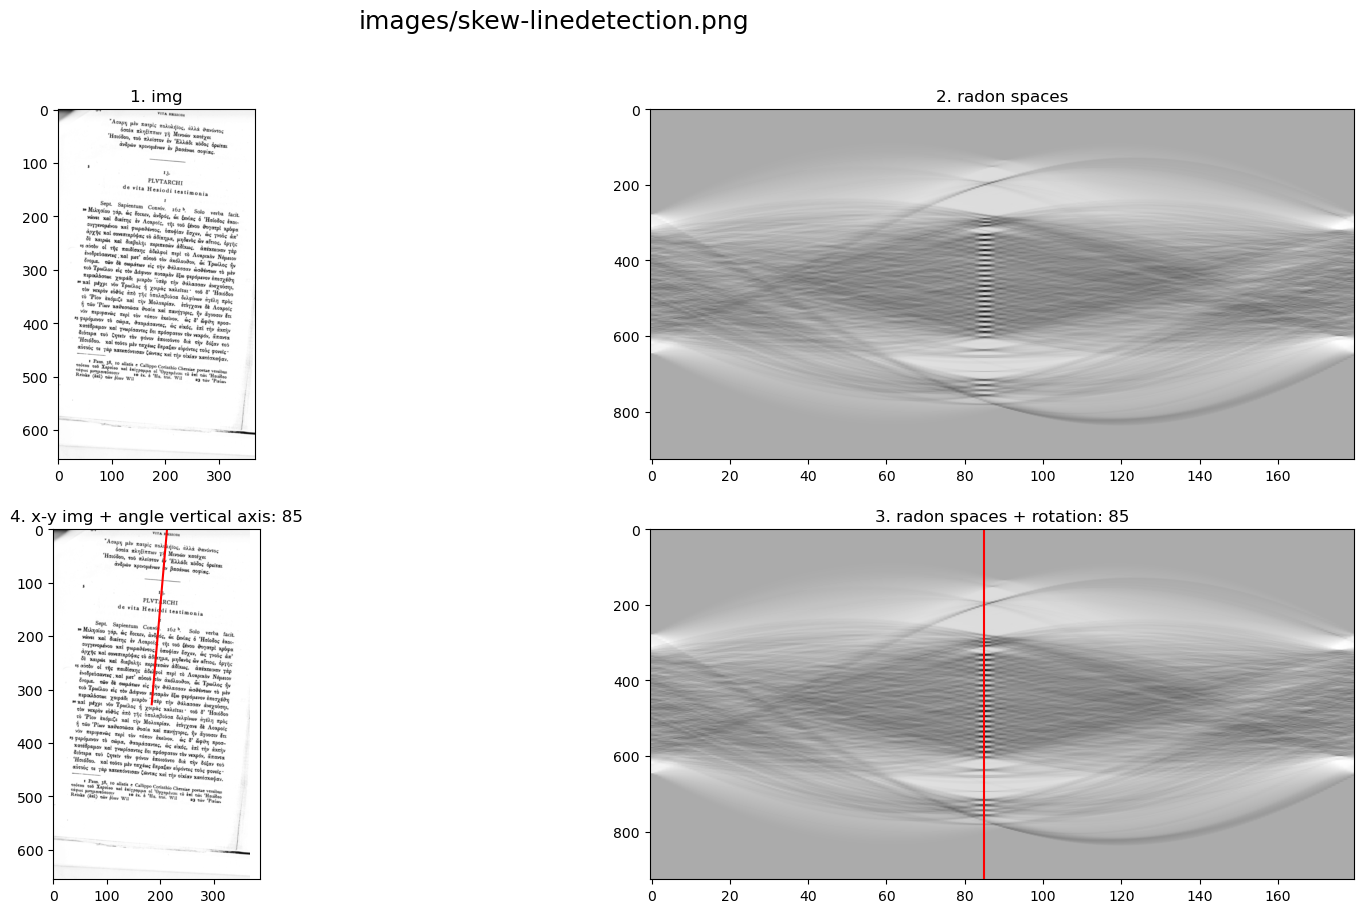

In [50]:
try:
    # More accurate peak finding from
    # https://gist.github.com/endolith/255291#file-parabolic-py
    from parabolic import parabolic

    def argmax(x):
        return parabolic(x, np.argmax(x))[0]
except ImportError:
    from numpy import argmax

def rms_flat(a):
    """
    Return the root mean square of all the elements of *a*, flattened out.
    """
    return np.sqrt(np.mean(np.abs(a) ** 2))

cached_angle_most = {}

for name,(sinogram) in cached_radon_space.items():
    start = time.time()

    img = cached_img_preprocess[name]
    img_size_h,img_size_w = img.shape[:2]
    img_size = np.array([img_size_w, img_size_h])
    img_center = tuple(img_size / 2)

    # Find the RMS value of each row and find "busiest" rotation,
    # where the transform is lined up perfectly with the alternating dark
    # text and white lines
    r = np.array([rms_flat(line) for line in sinogram.transpose()])
    rotation = argmax(r)


    # Image angle is the horizontal axis angle, vertical-angle need -90 deg
    # vertical-angle(vertical) of left-rotation relative to the x-y vertical-axis
    angle_deg_vertical_axis = rotation
    
    # to image horizontal-axis right-rotation angle
    angle_deg_skew = angle_deg_vertical_axis - 90

    # convert image horizontal-axis right-rotation angle to deskew angle
    rotation_deg_deskew = - angle_deg_skew

    end = time.time()
    cached_angle_most[name] = (angle_deg_skew, rotation_deg_deskew)


    print("name: ", name, "time: ", "{:.6f} seconds".format(end - start))

    fig = plt.figure(figsize=(20, 10))
    fig.suptitle(name, fontsize=18)
    gs = fig.add_gridspec(2, 2)

    img = cached_img_preprocess[name]
    ax = fig.add_subplot(gs[0, 0])
    ax.set_title(f"1. img")
    ax.imshow(img, cmap="gray", aspect='equal')

    ax = fig.add_subplot(gs[0, 1], aspect='auto')
    ax.set_title("2. radon spaces")
    ax.imshow(sinogram, cmap="gray", aspect='auto')

    ax = fig.add_subplot(gs[1, 1], aspect='auto')
    ax.set_title(f"3. radon spaces + rotation: {rotation}")
    ax.imshow(sinogram, cmap="gray", aspect='auto')
    plt.axvline(rotation, color='r')

    ax = fig.add_subplot(gs[1, 0], aspect='auto')
    ax.set_title(f"4. x-y img + angle vertical axis: {angle_deg_vertical_axis}")
    ax.imshow(img, cmap="gray", aspect='equal')
    ax.set_ylim(img.shape[0], 0)
    xc = img.shape[1] / 2
    yc = img.shape[0] / 2
    if angle_deg_vertical_axis > 90 and angle_deg_vertical_axis < 270:
        # left
        x2 = 0
        b = xc
    else:
        # right
        x2 = img.shape[1]
        b = -xc
    angle_rag_vertical_axis = np.deg2rad(angle_deg_vertical_axis)
    yc2 = b / np.cos(angle_rag_vertical_axis) * np.sin(angle_rag_vertical_axis)
    # 
    y2 = yc + yc2
    ax.plot((xc, x2), (yc, y2), '-', color='r')

df = pd.DataFrame.from_dict(cached_angle_most, orient='index', columns=['angle degree', 'rotation degree'])
display(df)

## deskew image

name:  images/skew-linedetection.png time:  0.002000 seconds


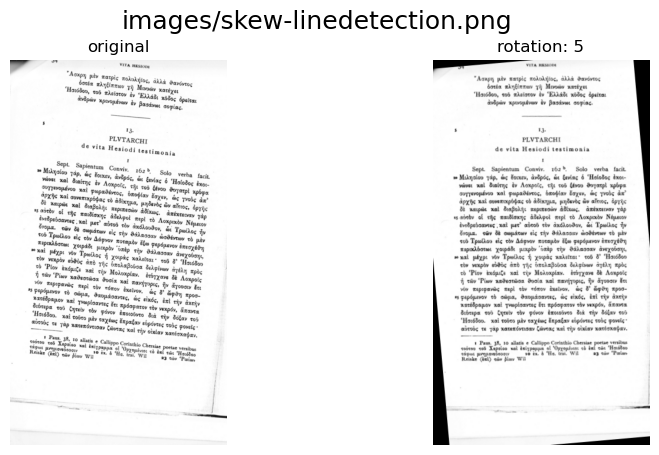

In [49]:
for name,(angle_deg,rotation_deg) in cached_angle_most.items():
    start = time.time()

    img,_ = cached_img_load[name]

    # Rotate original image
    img_center = tuple(np.array(img.shape[1::-1]) / 2)
    rotation_matrix = cv2.getRotationMatrix2D(img_center, rotation_deg, 1.0)
    img_rotated = cv2.warpAffine(img, rotation_matrix, img.shape[1::-1], flags=cv2.INTER_LINEAR)

    end = time.time()


    print("name: ", name, "time: ", "{:.6f} seconds".format(end - start))

    # show the output image
    imgs_show = [
        ("original", img),
        (f"rotation: {rotation_deg}", img_rotated)
    ]
    fig = plt.figure(figsize=(10,5))
    fig.suptitle(name, fontsize=18)
    gs = fig.add_gridspec(1,len(imgs_show))
    for idx, (name,img) in enumerate(imgs_show):
        ax = fig.add_subplot(gs[0, idx])
        ax.set_title(name)
        ax.axis('off')
        ax.imshow(img)
